# Overview

Using 600 MB of poem data, train a neural network that can spit out nice English poems.

### Surprises

use GRU. 

### Todo:
- [ ] get data

### Done:
- [x] Add temperature to generator
- [x] get training to work
- [x] use optim and Adam
- [x] add self-feeding generator

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils import forward_tracer, backward_tracer, Char2Vec, num_flat_features

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

from tqdm import tqdm

from IPython.display import clear_output

In [14]:
source = "";
with open('./data/shakespeare.txt', 'r') as f:
    for line in f:
        source += line + "\n"
        
source +=" " * 606
print([source[:60]])
len(source)

['First Citizen:\n\nBefore we proceed any further, hear me speak']


1156000

In [15]:
class GruRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers=1):
        super(GruRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = layers
        
        self.encoder = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, self.layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        self.softmax = F.softmax
        
    def forward(self, x, hidden):
        embeded = self.encoder(x)
        #print(embeded.view(-1, 1, self.input_size).size())
        gru_output, hidden = self.gru(embeded.view(-1, 1, self.input_size), hidden.view(self.layers, 1, -1))
        #print(gru_output.size())
        output = self.decoder(gru_output.view(-1, self.output_size))
        return output, hidden
    
    def init_hidden(self, random=False):
        if random:
            return Variable(torch.randn(layers, hidden_size))
        else:
            return Variable(torch.zeros(layers, hidden_size)) 
"""
input_size = 101
hidden_size = 101
output_size = 101
layers = 2

gRNN = GruRNN(input_size, hidden_size, output_size, layers)

gRNN(Variable(torch.FloatTensor(10000, 101)),
     Variable(torch.FloatTensor(layers, 101)))"""

'\ninput_size = 101\nhidden_size = 101\noutput_size = 101\nlayers = 2\n\ngRNN = GruRNN(input_size, hidden_size, output_size, layers)\n\ngRNN(Variable(torch.FloatTensor(10000, 101)),\n     Variable(torch.FloatTensor(layers, 101)))'

In [16]:
class Shakespeare():
    def __init__(self, model):
        self.model = model
        self.char2vec = Char2Vec()
        self.loss = 0
        self.losses = []
    
    def init_hidden_(self, random=False):
        self.hidden = model.init_hidden(random)
        return self
    
    def save(self, fn="GRU_Shakespeare.tar"):
        torch.save({
            "hidden": self.hidden, 
            "state_dict": model.state_dict(),
            "losses": self.losses
                   }, fn)
    
    def load(self, fn):
        checkpoint = torch.load(fn)
        self.hidden = checkpoint['hidden']
        model.load_state_dict(checkpoint['state_dict'])
        self.losses = checkpoint['losses']
    
    def setup_training(self, learning_rate):
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_fn = nn.CrossEntropyLoss()
        self.init_hidden_()
        
    def reset_loss(self):
        self.loss = 0
        
    def forward(self, input_text, target_text):
        
        self.hidden = self.hidden.detach()
        
        self.optimizer.zero_grad()
        self.next_(input_text)
        target_vec = Variable(self.char2vec.char_code(target_text))
        self.loss += self.loss_fn(self.output, target_vec)
        
    def descent(self):
        self.loss.backward()
        self.optimizer.step()
        self.losses.append(self.loss.cpu().data.numpy())
        self.reset_loss()
    
    def embed(self, input_data):
        self.embeded = Variable(self.char2vec.one_hot(input_data))
        return self.embeded
        
    def next_(self, input_text):
        self.output, self.hidden = self.model(self.embed(input_text), self.hidden)
        return self
    
    def softmax_(self, temperature=0.5):
        self.softmax = self.model.softmax(self.output/temperature)
        return self
    
    def text(self, start=None, end=None):
        indeces = torch.multinomial(self.softmax[start:end]).view(-1)
        return self.char2vec.vec2str(indeces)

In [29]:
input_size = 101 # len(char2vec.chars)
hidden_size = input_size
layers = 2

model = GruRNN(input_size, hidden_size, input_size, layers=layers)
william = Shakespeare(model)
#william.load('./data/Gru_Shakespeare_2_layer.tar')

In [30]:
learning_rate = 2e-3
william.setup_training(learning_rate)

Epoch 31


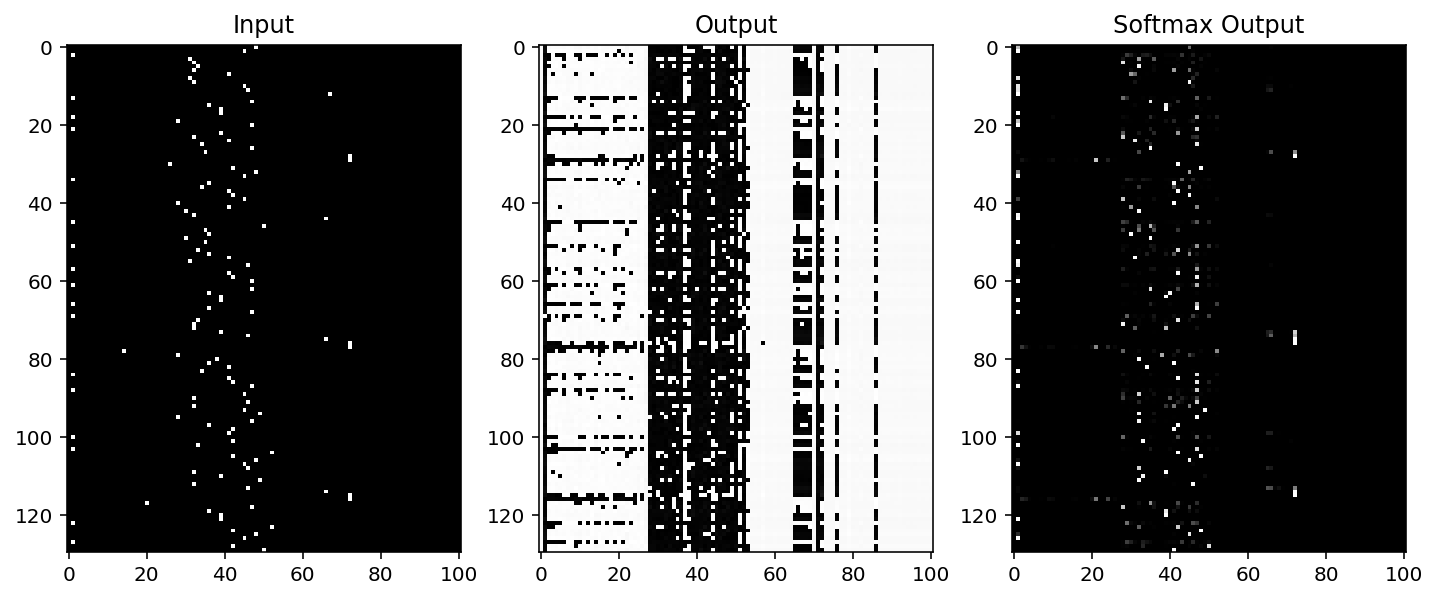

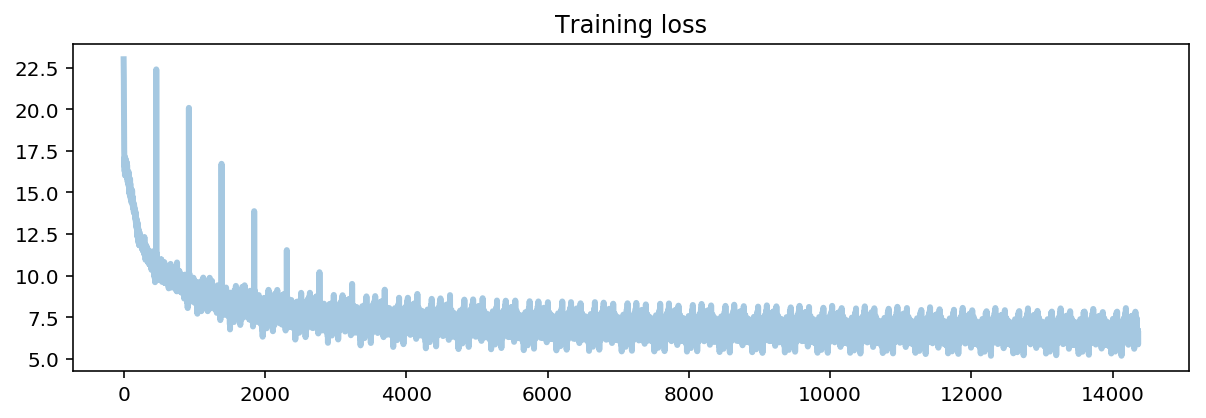

  9%|▊         | 201/2312 [01:07<18:28,  1.90it/s]

  feaenc rs  ahll t  haadthe
Tou  snror nte  feech tord  wot bhml ht woal
.

Wykeng tot tettnveteon wf tour .lfes.

Whall sour pun baos  aeaiver tourh


  9%|▉         | 209/2312 [01:10<08:52,  3.95it/s]

KeyboardInterrupt: 

In [31]:
model.zero_grad()
william.reset_loss()

seq_length = 500
batches = int(len(source)/seq_length)

for epoch_num in range(40):
    
    for step in tqdm(range(batches)):

        source_ = source[step*seq_length:(step+1)*seq_length]
        
        william.forward(source_, source_[1:] + " ")
        #william.descent()
        
        if step%5 == 4:
            william.descent()
        
        if step%200 == 199:
            clear_output(wait=True)
            print('Epoch {:d}'.format(epoch_num))

            william.softmax_()

            plt.figure(figsize=(12, 9))
            plt.subplot(131)
            plt.title("Input")
            plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(132)
            plt.title("Output")
            plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
            plt.subplot(133)
            plt.title("Softmax Output")
            plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
            plt.show()
            
            plt.figure(figsize=(10, 3))
            plt.title('Training loss')
            plt.plot(william.losses, label="loss", linewidth=3, alpha=0.4)
            plt.show()

            print(william.text(0,150))

## Now use the network to generate text!

In [32]:
# william.save('./data/Gru_Shakespeare_2_layer.tar')

In [33]:
from ipywidgets import widgets
from IPython.display import display

RsCondr

What shake then be then be the prison

That hath strong to the prison to the prince

That the prison that hath be consul than

The prince of the prison to the prison

That he will be the pri


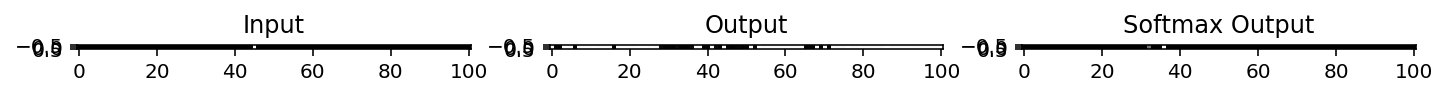

In [34]:
def predict_next(input_text, gen_length=None, temperature=0.05):
    
    if gen_length is None: 
        gen_length = len(input_text)
    
    clear_output(wait=True)
    william = Shakespeare(model).init_hidden_(random=True)
    
    william.next_(input_text)
    william.softmax_()
    string_output = william.text()
        
    for i in range(1, gen_length - len(input_text)):
        last_char = string_output[-1]
        william.next_(last_char)
        william.softmax_(temperature)
        string_output += william.text()
    
    print(string_output)
    
    plt.figure(figsize=(12, 9))
    plt.subplot(131)
    plt.title("Input")
    plt.imshow(william.embeded[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(132)
    plt.title("Output")
    plt.imshow(william.output[:130].data.byte().numpy(), cmap="Greys_r", interpolation="none")
    plt.subplot(133)
    plt.title("Softmax Output")
    plt.imshow(william.softmax[:130].cpu().data.numpy(), cmap="Greys_r", interpolation="none")
    plt.show()

predict_next("Ge Yang:\n", 200)

wqdhanrsanger:

This be go after got the mark be

Than be take their voices and promise

And the rest you to do so down.



CORIOLANUS:

Come, father, by the ears and consul,

The senate that in his advise it

Be it be the world that you have beat

The present be spent the consupply,

That hath stand to the deeds to him

And be words to the prince should have done.



CORIOLANUS:

What hath there the prays in the senater since offent

A son so stop the peace?



CORIOLANUS:

I will not have beat the present of the consul

That the people he to contempt and one

Hang the sprives hath a parted to be so,

You shall be so believe them.



CORIOLANUS:

He will say you so the prayers to her heart.



CORIOLANUS:

Be all the friends of the serve to know,

The world to the prison be stay will be

That senate not the entreating their

With the hath served to creck at the ridges

The manise and draw the appetite out

In that the very news being sanctures,

That he did ready a prince speak'd us,


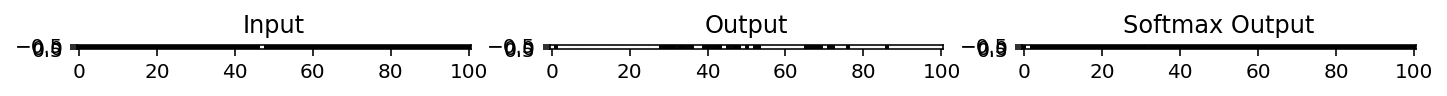

In [35]:
text_input = widgets.Text()
display(text_input)

def handle_submit(sender):
    #print(text_input.value)
    predict_next(text_input.value, 2000, temperature=0.5)
    
text_input.on_submit(handle_submit)

The ge